In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from make_rankings import *
import os.path

# IMPORTING SPEEDRUN DATA

When importing, "duplicate" runs (ie multiple runs on the same quest, by the same runner, using the same weapon) are eliminated, so that only the fastest of the duplicates remains

In [2]:
#Check for existence of freestyle.csv and ta.csv
if os.path.exists('freestyle.csv') and os.path.exists('ta.csv'):
    freestyle = pd.read_csv('freestyle.csv')
    ta = pd.read_csv('ta.csv')

else:
    #Get Freestyle and TA rankings from 'speedrun_data.csv'
    freestyle,ta = make_rankings('speedrun_data.csv')

In [3]:
#Prepare figure properties for later graphs
figure_size = (16,7)
font_size = 20

# 1. - INITIAL ANALYSIS
### Check the average clear time per weapon

Text(0.5, 1.0, 'Average clear time by Monster - TA')

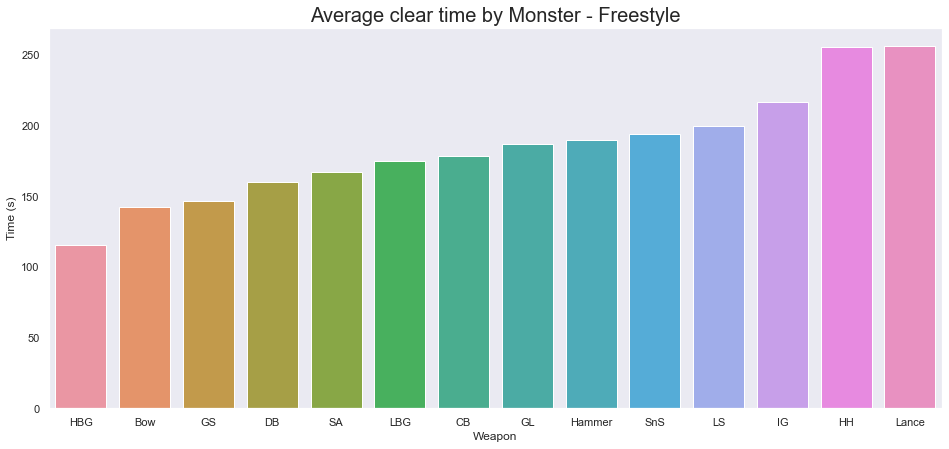

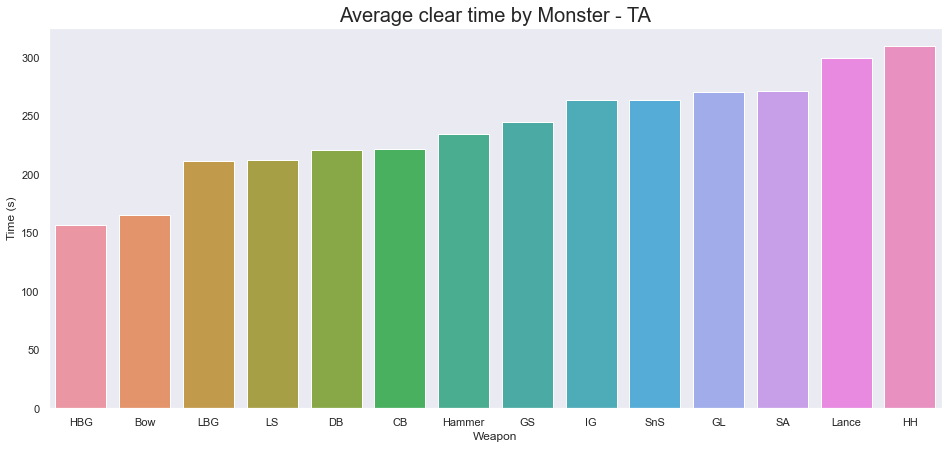

In [4]:
#Very early analysis: just get average TOP clear time by weapons/monsters

avg_freestyle = average_top_runs(freestyle,'Monster/Weapon')
avg_ta = average_top_runs(ta,'Monster/Weapon')

#Plot average freestyle times
sns.set_context('notebook')
sns.set_style('dark')

plt.figure(figsize=figure_size)
sns.barplot(x='Weapon',y='Time (s)',data=avg_freestyle).set_title('Average clear time by Monster - Freestyle',fontsize=font_size)

#Plot average TA times
plt.figure(figsize=figure_size)
sns.barplot(x='Weapon',y='Time (s)',data=avg_ta).set_title('Average clear time by Monster - TA',fontsize=font_size)

Text(0.5, 1.0, 'Average clear time by Quest - TA Rules')

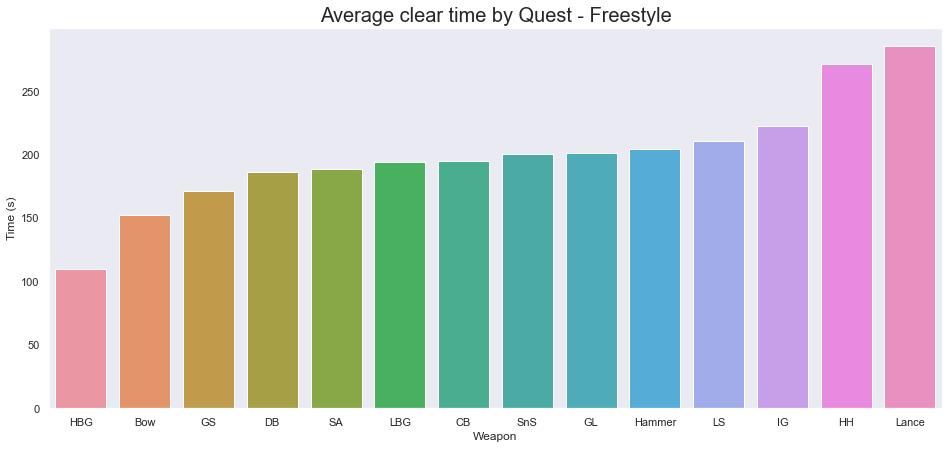

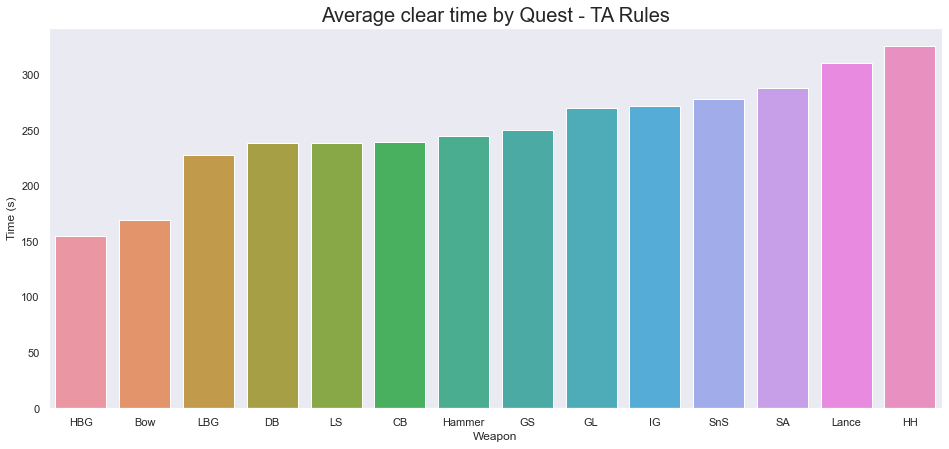

In [5]:
#Same analysis, but considering top times by weapon/QUEST

avg_freestyle = average_top_runs(freestyle,'Quest/Weapon')
avg_ta = average_top_runs(ta,'Quest/Weapon')

plt.figure(figsize=figure_size)
sns.barplot(x='Weapon',y='Time (s)',data=avg_freestyle).set_title('Average clear time by Quest - Freestyle',fontsize=font_size)

plt.figure(figsize=figure_size)
sns.barplot(x='Weapon',y='Time (s)',data=avg_ta).set_title('Average clear time by Quest - TA Rules',fontsize=font_size)

# 2. - SECOND ANALYSIS
### Check the average clear time of *only the fastest runs* per weapon

Text(0.5, 1.0, 'Average TOP clear time by Monster - TA')

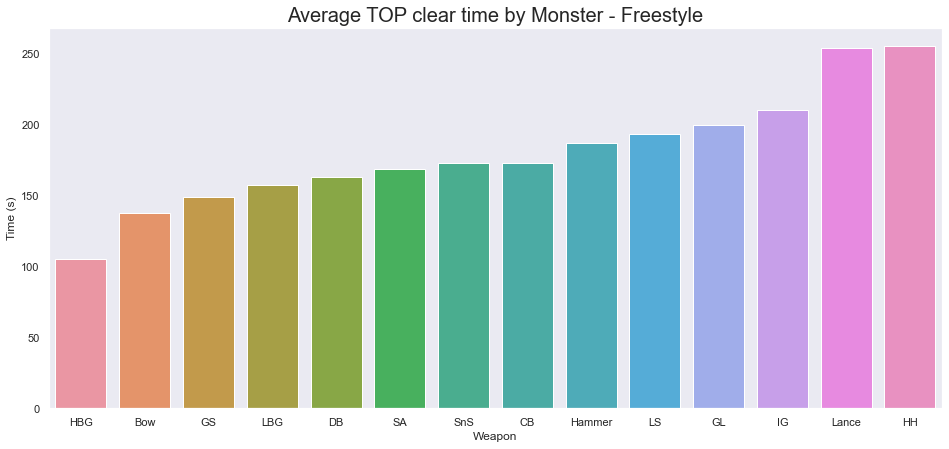

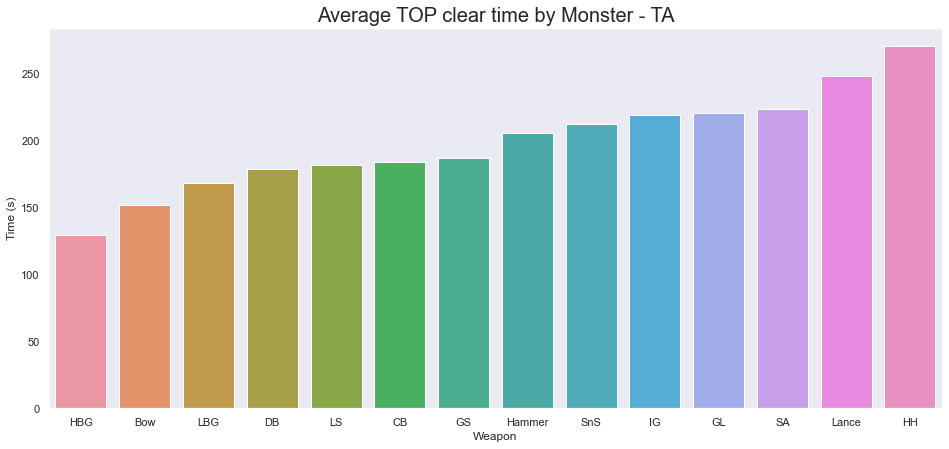

In [6]:
#Second analysis: filter only the top runs and see the average times

fs_all_weapons = filter_by_weapon(freestyle)
ta_all_weapons = filter_by_weapon(ta)

#Get average times
fs_aw_avg = average_top_runs(fs_all_weapons,'Monster/Weapon')
ta_aw_avg = average_top_runs(ta_all_weapons,'Monster/Weapon')

plt.figure(figsize=figure_size)
sns.barplot(x='Weapon',y='Time (s)',data=fs_aw_avg).set_title('Average TOP clear time by Monster - Freestyle', fontsize =font_size)

plt.figure(figsize=figure_size)
sns.barplot(x='Weapon',y='Time (s)',data=ta_aw_avg).set_title('Average TOP clear time by Monster - TA', fontsize =font_size)

In [7]:
#Create 'Weapon (long)' column to have long form weapon names
#First, get the inverse weapon_dict to go from short names to long names
inv_weapon_dict = {value: key for key, value in weapon_dict.items()}

#Apply mapping from inv_weapon-dict
fs_aw_avg['Weapon (long)']=fs_aw_avg['Weapon'].apply(lambda x: inv_weapon_dict[x])
fs_aw_avg['Time (s)']=fs_aw_avg['Time (s)'].apply(lambda x: round(x,2))
ta_aw_avg['Weapon (long)']=ta_aw_avg['Weapon'].apply(lambda x: inv_weapon_dict[x])

#Numerical values
print('Freestyle average top clear times per weapon (1 entry per monster)')
print(fs_aw_avg[['Weapon (long)','Time (s)']])
print('\nTA Rules average top clear times per weapon (1 entry per monster)')
print(ta_aw_avg[['Weapon (long)','Time (s)']])

Freestyle average top clear times per weapon (1 entry per monster)
       Weapon (long)  Time (s)
1       Heavy Bowgun    105.44
2                Bow    137.73
3        Great Sword    148.88
4       Light Bowgun    157.27
5        Dual Blades    162.87
6         Switch Axe    168.46
7   Sword And Shield    172.39
8       Charge Blade    172.94
9             Hammer    186.89
10        Long Sword    192.95
11          Gunlance    199.15
12     Insect Glaive    210.09
13             Lance    253.52
14      Hunting Horn    255.17

TA Rules average top clear times per weapon (1 entry per monster)
       Weapon (long)  Time (s)
1       Heavy Bowgun    129.41
2                Bow    151.84
3       Light Bowgun    168.43
4        Dual Blades    178.61
5         Long Sword    182.31
6       Charge Blade    183.87
7        Great Sword    187.21
8             Hammer    205.73
9   Sword And Shield    212.51
10     Insect Glaive    219.02
11          Gunlance    220.79
12        Switch Axe    223.6

Text(0.5, 1.0, 'Average TOP clear time by Monster - TA')

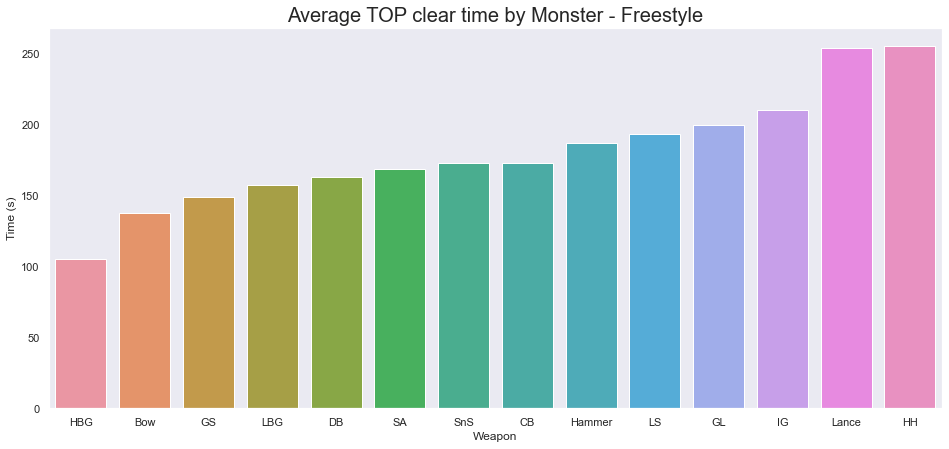

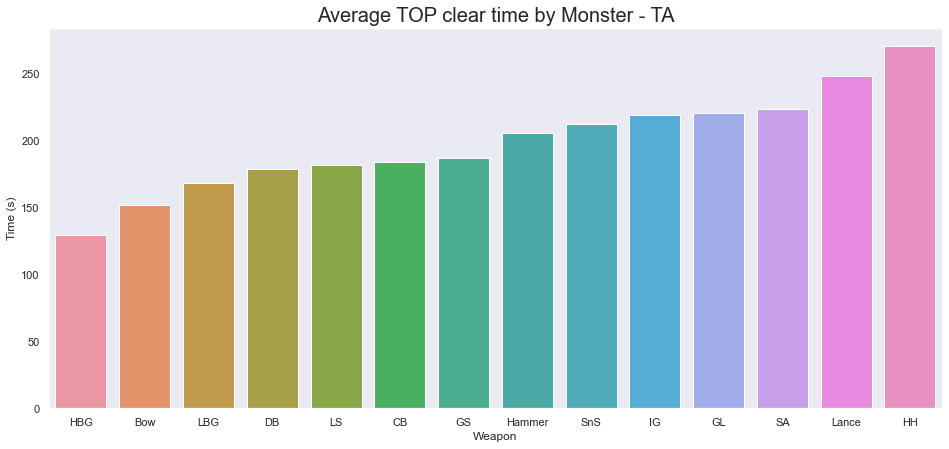

In [8]:
#Now repeat second analysis, but separate entries by Quest rather than Monster

fs_all_weapons = filter_by_weapon(freestyle)
ta_all_weapons = filter_by_weapon(ta)

fs_aw_avg_q = average_top_runs(fs_all_weapons,'Quest/Weapon')
ta_aw_avg_q = average_top_runs(ta_all_weapons,'Quest/Weapon')

plt.figure(figsize=figure_size)
sns.barplot(x='Weapon',y='Time (s)',data=fs_aw_avg).set_title('Average TOP clear time by Monster - Freestyle', fontsize =font_size)

plt.figure(figsize=figure_size)
sns.barplot(x='Weapon',y='Time (s)',data=ta_aw_avg).set_title('Average TOP clear time by Monster - TA', fontsize =font_size)

In [9]:
#Create 'Weapon (long)' column to have long form weapon names
#First, get the inverse weapon_dict to go from short names to long names
inv_weapon_dict = {value: key for key, value in weapon_dict.items()}

#Apply mapping from inv_weapon-dict
fs_aw_avg_q['Weapon (long)']=fs_aw_avg_q['Weapon'].apply(lambda x: inv_weapon_dict[x])
ta_aw_avg_q['Weapon (long)']=ta_aw_avg_q['Weapon'].apply(lambda x: inv_weapon_dict[x])

#Numerical values
print('Freestyle average top clear times per weapon (1 entry per Quest)')
print(fs_aw_avg_q[['Weapon (long)','Time (s)']])
print('\nTA Rules average top clear times per weapon (1 entry per Quest)')
print(ta_aw_avg_q[['Weapon (long)','Time (s)']])

Freestyle average top clear times per weapon (1 entry per Quest)
       Weapon (long)  Time (s)
1       Heavy Bowgun     99.54
2                Bow    141.81
3        Great Sword    156.74
4       Light Bowgun    166.75
5        Dual Blades    170.10
6   Sword And Shield    175.03
7         Switch Axe    175.23
8       Charge Blade    178.55
9         Long Sword    198.30
10            Hammer    199.12
11          Gunlance    204.37
12     Insect Glaive    216.13
13             Lance    265.94
14      Hunting Horn    266.89

TA Rules average top clear times per weapon (1 entry per Quest)
       Weapon (long)  Time (s)
1       Heavy Bowgun    129.41
2                Bow    148.56
3       Light Bowgun    168.43
4        Dual Blades    179.00
5         Long Sword    184.41
6        Great Sword    187.21
7       Charge Blade    187.30
8             Hammer    205.73
9   Sword And Shield    212.51
10     Insect Glaive    218.71
11        Switch Axe    220.35
12          Gunlance    220.79
13

## 2.1 - TIER LISTS BASED ON SECOND ANALYSIS

Weapons will be classified in 'n_tiers' tiers, as chosen by the user.

In [10]:
#Make some tier lists

#Freestyle
tl_fs_quest   = make_tiers(fs_aw_avg_q,n_tiers=7) #By quest
tl_fs_monster = make_tiers(fs_aw_avg,n_tiers=7)   #By monster

#TA
tl_ta_quest   = make_tiers(ta_aw_avg_q,n_tiers=7) #By quest
tl_ta_monster = make_tiers(ta_aw_avg,n_tiers=7)   #By monster

In [11]:
#Display tier lists

print('Freestyle Tier list - Best times by MONSTER')
tl_fs_monster

Freestyle Tier list - Best times by MONSTER


,Average Times,Weapons
Tier,,
S,Less than 118.0 s,Heavy Bowgun
A,118.0 s - 143.0 s,Bow
B,143.0 s - 168.0 s,"Great Sword, Light Bowgun, Dual Blades"
C,168.0 s - 193.0 s,"Switch Axe, Sword And Shield, Charge Blade, Hammer, Long Sword"
D,193.0 s - 218.0 s,"Gunlance, Insect Glaive"
E,218.0 s - 243.0 s,
F,More than 243.0 s,"Lance, Hunting Horn"


In [12]:
print('Freestyle Tier list - Best times by QUEST')
tl_fs_quest

Freestyle Tier list - Best times by QUEST


,Average Times,Weapons
Tier,,
S,Less than 113.0 s,Heavy Bowgun
A,113.0 s - 140.0 s,
B,140.0 s - 167.0 s,"Bow, Great Sword, Light Bowgun"
C,167.0 s - 194.0 s,"Dual Blades, Sword And Shield, Switch Axe, Charge Blade"
D,194.0 s - 221.0 s,"Long Sword, Hammer, Gunlance, Insect Glaive"
E,221.0 s - 248.0 s,
F,More than 248.0 s,"Lance, Hunting Horn"


In [13]:
print('TA Rules Tier list - Best times by MONSTER')
tl_ta_monster

TA Rules Tier list - Best times by MONSTER


,Average Times,Weapons
Tier,,
S,Less than 141.0 s,Heavy Bowgun
A,141.0 s - 164.0 s,Bow
B,164.0 s - 187.0 s,"Light Bowgun, Dual Blades, Long Sword, Charge Blade"
C,187.0 s - 210.0 s,"Great Sword, Hammer"
D,210.0 s - 233.0 s,"Sword And Shield, Insect Glaive, Gunlance, Switch Axe"
E,233.0 s - 256.0 s,Lance
F,More than 256.0 s,Hunting Horn


In [14]:
print('TA Rules Tier list - Best times by QUEST')
tl_ta_quest

TA Rules Tier list - Best times by QUEST


,Average Times,Weapons
Tier,,
S,Less than 141.0 s,Heavy Bowgun
A,141.0 s - 164.0 s,Bow
B,164.0 s - 187.0 s,"Light Bowgun, Dual Blades, Long Sword"
C,187.0 s - 210.0 s,"Great Sword, Charge Blade, Hammer"
D,210.0 s - 233.0 s,"Sword And Shield, Insect Glaive, Switch Axe, Gunlance"
E,233.0 s - 256.0 s,Lance
F,More than 256.0 s,Hunting Horn


# 3. - REMOVE OUTLIERS, THEN RANK
Find out which speedrun times are outliers (too fast or too slow for a given weapon), remove these quests and then proceed with a tier list analysis, as done in section 2

## 3.1 - BOXPLOTS
Do some boxplots to quickly see the outliers

Text(0.5, 1.0, 'TA runs')

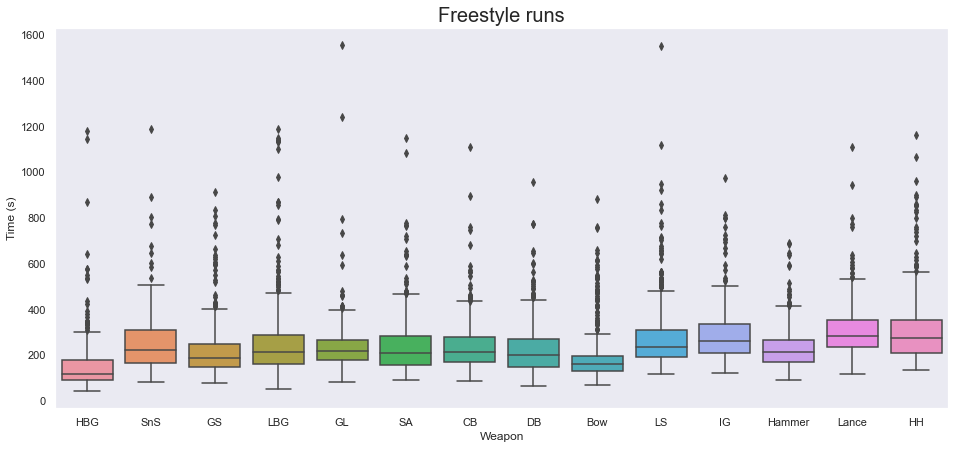

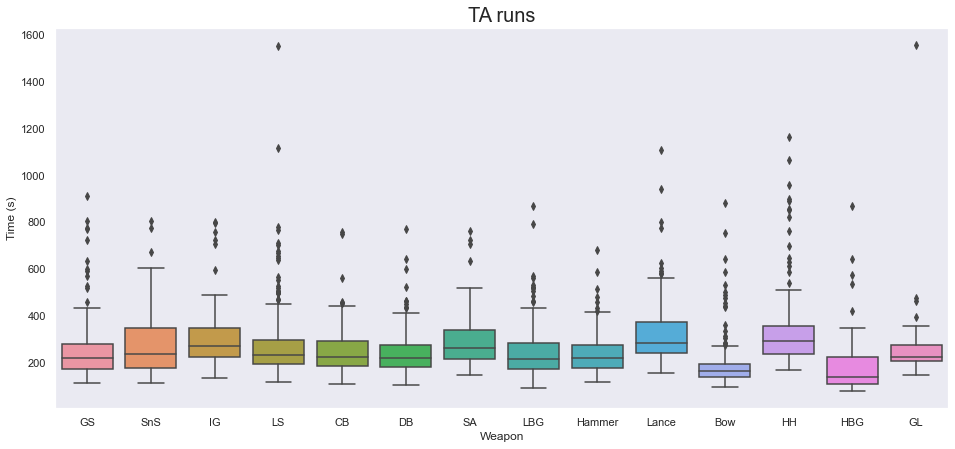

In [21]:
#Freestyle runs
plt.figure(figsize=figure_size)
sns.boxplot(x='Weapon',y='Time (s)',data=freestyle).set_title("Freestyle runs",fontsize=font_size)

#TA runs
plt.figure(figsize=figure_size)
sns.boxplot(x='Weapon',y='Time (s)',data=ta).set_title("TA runs",fontsize=font_size)

Text(0.5, 1.0, 'Freestyle runs - No Outliers')

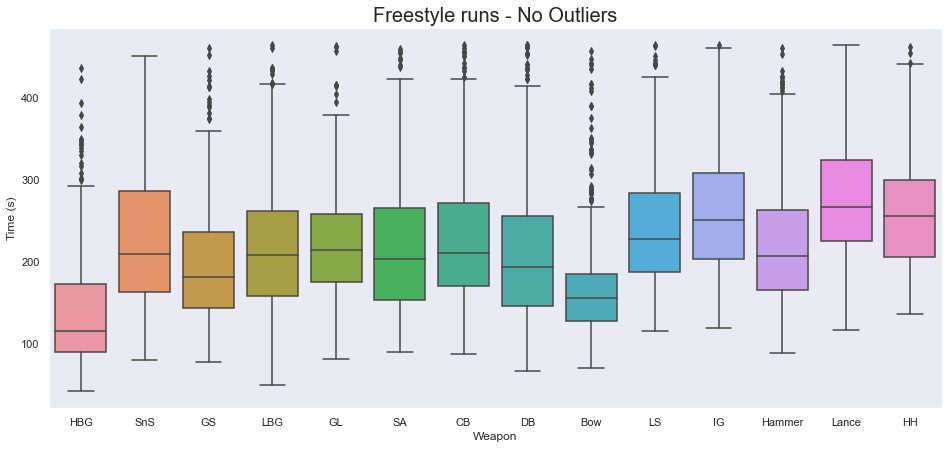

In [33]:
#Define our quantiles
Q1 = freestyle['Time (s)'].quantile(0.25)
Q3 = freestyle['Time (s)'].quantile(0.75)
IQR = Q3 - Q1

fs_out = freestyle[~((freestyle['Time (s)'] < (Q1 - 1.5 * IQR)) | (freestyle['Time (s)'] > (Q3 + 1.5 * IQR)))]

# Plot to check
plt.figure(figsize=figure_size)
sns.boxplot(x='Weapon',y='Time (s)',data=fs_out).set_title("Freestyle runs - No Outliers",fontsize=font_size)